### Initialization

In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
import copy 
import os

import torch
import torchvision

import pandas as pd
import sklearn

from torchvision import transforms, utils
import PIL
from torch.autograd import Variable


import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [2]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=5cde4d5d01667a1754746c4619db50d3a392ad03fa5e34112a158b5f0b7baf39
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p data
!cp '/content/drive/Shareddrives/UCI CS175 Team23/training_solutions_rev1.csv' ./data/
!unzip -q -u '/content/drive/Shareddrives/UCI CS175 Team23/images_training_rev1.zip' -d ./data/

In [5]:
!ls data

images_training_rev1  training_solutions_rev1.csv


In [6]:
training_data_path = '/content/data/images_training_rev1'
solution_path = '/content/data/training_solutions_rev1.csv'

In [7]:
df = pd.read_csv(solution_path)

In [8]:
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,Class5.2,Class5.3,Class5.4,Class6.1,Class6.2,Class7.1,Class7.2,Class7.3,Class8.1,Class8.2,Class8.3,Class8.4,Class8.5,Class8.6,Class8.7,Class9.1,Class9.2,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61578 entries, 0 to 61577
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GalaxyID   61578 non-null  int64  
 1   Class1.1   61578 non-null  float64
 2   Class1.2   61578 non-null  float64
 3   Class1.3   61578 non-null  float64
 4   Class2.1   61578 non-null  float64
 5   Class2.2   61578 non-null  float64
 6   Class3.1   61578 non-null  float64
 7   Class3.2   61578 non-null  float64
 8   Class4.1   61578 non-null  float64
 9   Class4.2   61578 non-null  float64
 10  Class5.1   61578 non-null  float64
 11  Class5.2   61578 non-null  float64
 12  Class5.3   61578 non-null  float64
 13  Class5.4   61578 non-null  float64
 14  Class6.1   61578 non-null  float64
 15  Class6.2   61578 non-null  float64
 16  Class7.1   61578 non-null  float64
 17  Class7.2   61578 non-null  float64
 18  Class7.3   61578 non-null  float64
 19  Class8.1   61578 non-null  float64
 20  Class8

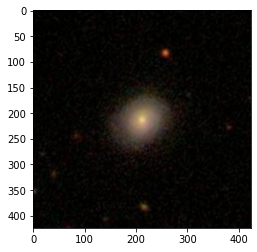

In [10]:
plt.imshow(plt.imread(training_data_path + "/" + str(df["GalaxyID"][0]) + ".jpg"))

### Preprocessing


In [11]:
# reference: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
class GalaxyDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, usr_root_dir, usr_transforms=None):
    self.solution = pd.read_csv(solution_path)
    self.root_dir = usr_root_dir
    self.transforms = usr_transforms

  def __len__(self):
    return len(self.solution)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_name = self.root_dir + "/" + str(self.solution.iloc[idx,0]) + ".jpg"
    id = self.solution.iloc[idx,0]
    #image = plt.imread(img_name).T
    image = PIL.Image.open((img_name))
    image = self.transforms(image)
    proba = self.solution.iloc[idx,1:].to_numpy()
    #image = np.moveaxis(image.numpy()*255, 0, -1).astype("uint8")
    return  image, proba, id

In [12]:
galaxy_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    ])

tri_full = GalaxyDataset(solution_path, training_data_path, galaxy_transform)

In [13]:
def show_image(sample_image):
  example_img = np.moveaxis(sample_image.numpy()*255, 0, -1).astype("uint8")
  plt.imshow(example_img)
  return example_img

array([[[5, 5, 3],
        [5, 5, 3],
        [2, 2, 1],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[7, 7, 5],
        [6, 6, 4],
        [2, 2, 1],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[3, 3, 1],
        [4, 4, 2],
        [3, 3, 1],
        ...,
        [1, 1, 1],
        [2, 2, 2],
        [2, 2, 2]],

       ...,

       [[5, 5, 3],
        [4, 4, 2],
        [2, 2, 0],
        ...,
        [6, 6, 4],
        [6, 6, 4],
        [2, 2, 1]],

       [[5, 5, 3],
        [4, 4, 2],
        [2, 2, 0],
        ...,
        [6, 6, 4],
        [5, 5, 3],
        [1, 1, 0]],

       [[5, 5, 3],
        [4, 4, 2],
        [2, 2, 0],
        ...,
        [3, 3, 1],
        [2, 2, 0],
        [1, 1, 0]]], dtype=uint8)

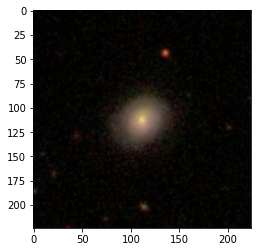

In [14]:
show_image(tri_full[0][0])

In [15]:
a, b = torch.utils.data.random_split(tri_full, [43104, 18474], torch.Generator().manual_seed(1234))

loader_train = torch.utils.data.DataLoader(a, batch_size=64)
loader_valid = torch.utils.data.DataLoader(b)

loader_train_full = torch.utils.data.DataLoader(tri_full)

gpu_dtype = torch.cuda.FloatTensor

### Design training and testing functions

In [16]:
def custom_train(model, loss_fn, optimizer, num_epochs = 1):
    epoch_log = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()

        t_log = []
        for t, (x, y, _) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype))
            
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            
            if (t + 1) % 500 == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.item()))
            t_log.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_log.append(max(t_log))   
    
    fig = plt.figure(figsize=(7,7))
    plt.plot(epoch_log)
    plt.ylim(0, 3)
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [17]:
def check_accuracy(model, loader, num_sample):
    model.eval() 
    #temp = torch.ones([1,37]).type(gpu_dtype)
    temp = 0
    count = 0
    with torch.no_grad():
      for x, y, id in loader:
          # 
          x_var = Variable(x.type(gpu_dtype))
          y_var = Variable(y.type(gpu_dtype))
          
          scores = model(x_var)
          scores[scores < 0] = 0
          diff = y_var - scores
          

          # print(scores)
          # print(y_var)
          # print(diff , "\n")
          #temp += torch.square(diff)
          temp += torch.sqrt(torch.mean(torch.square(diff)))
          #temp += diff
          count += 1
          if num_sample == count:
            break
    print(temp / num_sample)
    #print(torch.sqrt(torch.mean(torch.div(temp, len(loader)))))
    print( temp / len(loader) )
    #print(torch.sqrt(torch.mean(torch.square(torch.div(temp, len(loader))))))
  

In [18]:
!cp '/content/drive/Shareddrives/UCI CS175 Team23/images_test_rev1.zip' ./data/
!unzip -q -u '/content/drive/Shareddrives/UCI CS175 Team23/images_test_rev1.zip' -d ./data/
!ls data

images_test_rev1      images_training_rev1
images_test_rev1.zip  training_solutions_rev1.csv


In [19]:
class GalaxyTestDataset(torch.utils.data.Dataset):
  def __init__(self, usr_root_dir, usr_transforms=None):
    self.root_dir = usr_root_dir
    self.transforms = usr_transforms
    self.images_path = os.listdir(usr_root_dir)

  def __len__(self):
    return len(self.images_path)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    self.images_path.sort()
    file_paths = self.images_path
    img_name = self.root_dir + "/" + file_paths[idx]
    id = int(file_paths[idx].split(".")[0])

    image = PIL.Image.open((img_name))
    image = self.transforms(image)

    return  image, id

In [20]:
test_data_path = '/content/data/images_test_rev1'
test_full = GalaxyTestDataset(test_data_path, galaxy_transform)

In [21]:
def write_prediction(model, loader, output_name, header_list):
  model.eval() 
  num_sample = len(loader)

  numpy_temp = np.ones((num_sample, 38))

  count = 0
  with torch.no_grad():
    for x, id in loader:
        x_var = Variable(x.type(gpu_dtype))

        scores = model(x_var)
        scores[scores < 0] = 0
        scores[scores > 1] = 1
        
        scores_numpy = scores.cpu().detach().numpy()

        
        numpy_temp[count][0] = id
        numpy_temp[count][1:] = scores_numpy

        count += 1

  something = pd.DataFrame(numpy_temp)

  something.columns = header_list
  something = something.astype({"GalaxyID": "int64"})

  print(something.head())

  something.to_csv(output_name,  index=False)

  return numpy_temp

In [22]:
loader_test = torch.utils.data.DataLoader(test_full)

### Load current models

In [51]:
loaded_model = torch.load('/content/drive/Shareddrives/UCI CS175 Team23/effnet-b2-full.pt' )

In [49]:
check_accuracy(loaded_model, loader_valid, 10)

tensor(0.0937, device='cuda:0')
tensor(5.0714e-05, device='cuda:0')


### Visualization

In [23]:
# Visualization results
'''
Q1. Is the object a smooth galaxy, a galaxy with features/disk or a star? 3 responses
Q2. Is it edge-on? 2 responses
Q3. Is there a bar? 2 responses
Q4. Is there a spiral pattern? 2 responses
Q5. How prominent is the central bulge? 4 responses
Q6. Is there anything "odd" about the galaxy? 2 responses
Q7. How round is the smooth galaxy? 3 responses
Q8. What is the odd feature? 7 responses
Q9. What shape is the bulge in the edge-on galaxy? 3 responses
Q10. How tightly wound are the spiral arms? 3 responses
Q11. How many spiral arms are there? 6 responses
'''

def findExampleImage(image_dataset, num_sample):
  imageC11  = []
  imageC12  = []
  imageC13  = []

  for image, y_label, id in tri_full:
    if y_label[0] > 0.7:
      imageC11.append(image)

    if y_label[1] > 0.7:
      imageC12.append(image)
    
    if y_label[2] > 0.3:
      imageC13.append(image)

    if (len(imageC13) == num_sample):
      break
  return imageC11, imageC12, imageC13



In [24]:
im1, im2, im3 = findExampleImage(tri_full, 3)

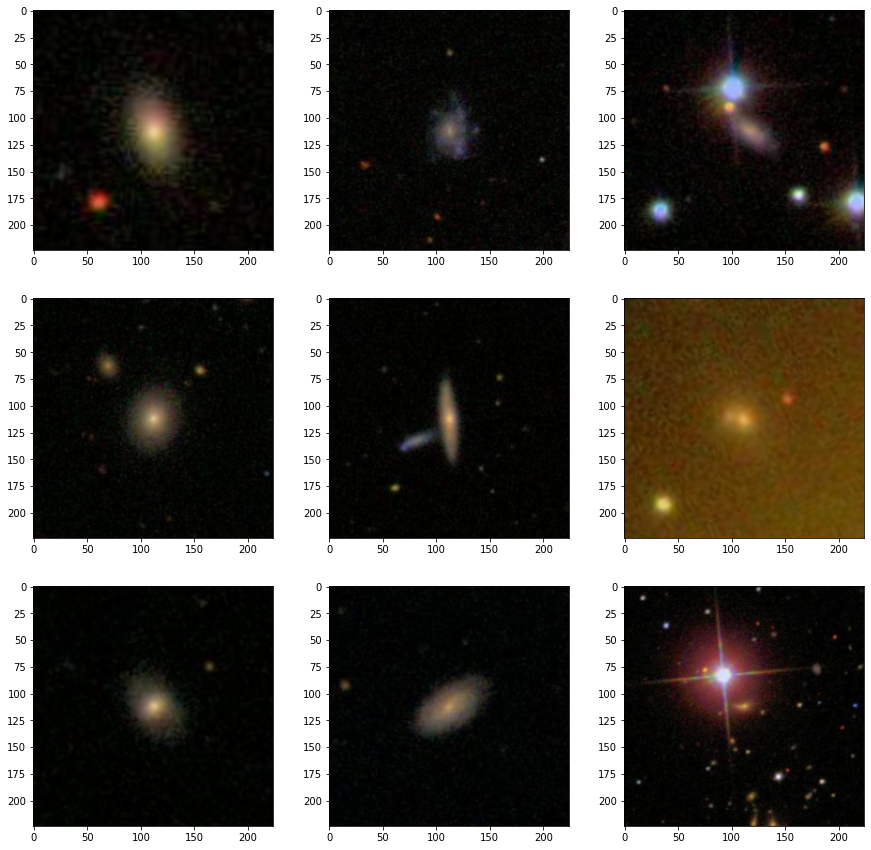

In [25]:
fig, ax = plt.subplots(3,3,figsize=(15,15))

for i in range(3):

  ax[i, 0].imshow(show_image(im1[i]))
  ax[i, 1].imshow(show_image(im2[i]))
  ax[i, 2].imshow(show_image(im3[i]))


In [58]:
!cp   '/content/drive/Shareddrives/UCI CS175 Team23/resnet-full-best.csv' .

cp: cannot stat '/content/drive/Shareddrives/UCI CS175 Team23/resnet-full-best.csv': No such file or directory


In [59]:
sample_pred = pd.read_csv("resnet_full-best.csv")
sample_pred_np = sample_pred.to_numpy()

In [ ]:
sample_pred_np[:5]

In [74]:
def findExampleImage_test(pred, idx, num_sample, prob):
  imageC = []
  for i in range(len(pred)):
    k = np.random.choice(len(pred))
    image_path = test_data_path + "/" + str(int(pred[k][0])) + ".jpg"
    image = PIL.Image.open(image_path)
    image = galaxy_transform(image)
    y_label = pred[k][:3]

    if y_label[idx] >  prob:
      imageC.append(image)

    if len(imageC) == num_sample:
      break
  return imageC

In [79]:
imt1 = findExampleImage_test(sample_pred_np, 0, 3, 0.7)
imt2 = findExampleImage_test(sample_pred_np, 1, 3, 0.7)
imt3 = findExampleImage_test(sample_pred_np, 2, 3, 0.7)

In [33]:
print(len(imt1), len(imt2), len(imt3))

3 3 3


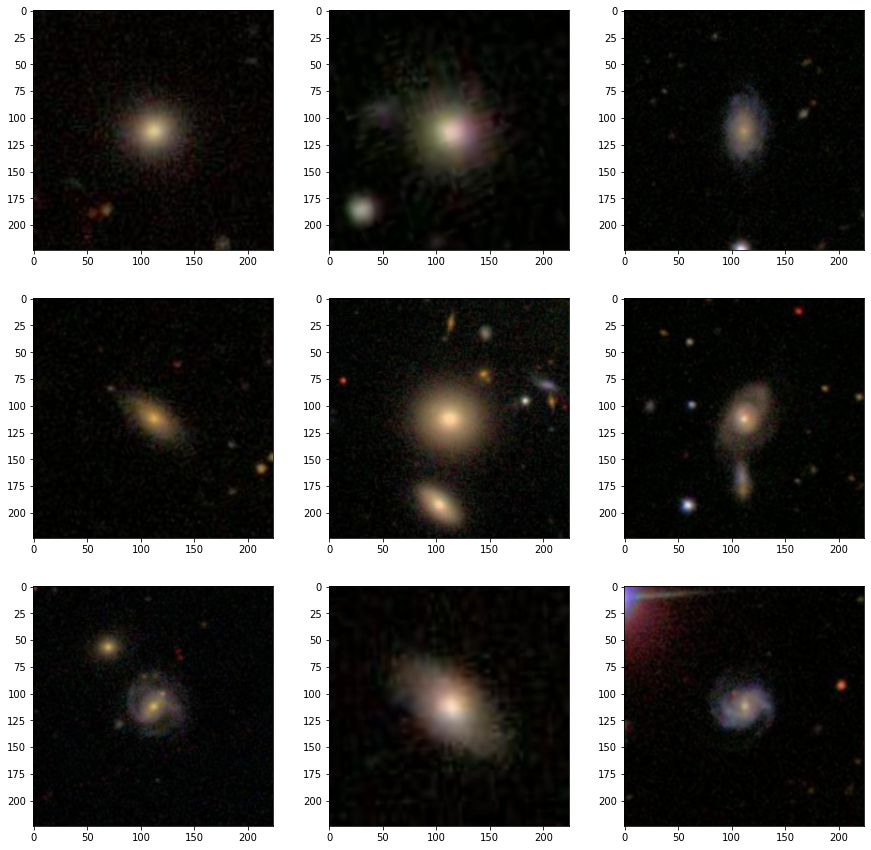

In [80]:
fig, ax = plt.subplots(3,3,figsize=(15,15))
 
for i in range(3):

  ax[i, 0].imshow(show_image(imt1[i]))
  ax[i, 1].imshow(show_image(imt2[i]))
  ax[i, 2].imshow(show_image(imt3[i]))